In [1]:
# General
import pickle
import pandas as pd
import numpy as np
import datetime
from scipy import stats
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# SARIMAX
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


# Set options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)



In [2]:
# Load data, sort on zip and date and set index to datetime
with open("../data/sfr_mfr_mig_pre-processed.pkl", "rb") as f:
    data = pickle.load(f)
data.sort_values(['census_cbsa_geoid', 'census_zcta5_geoid', 'date'])
data.set_index('date', inplace=True)

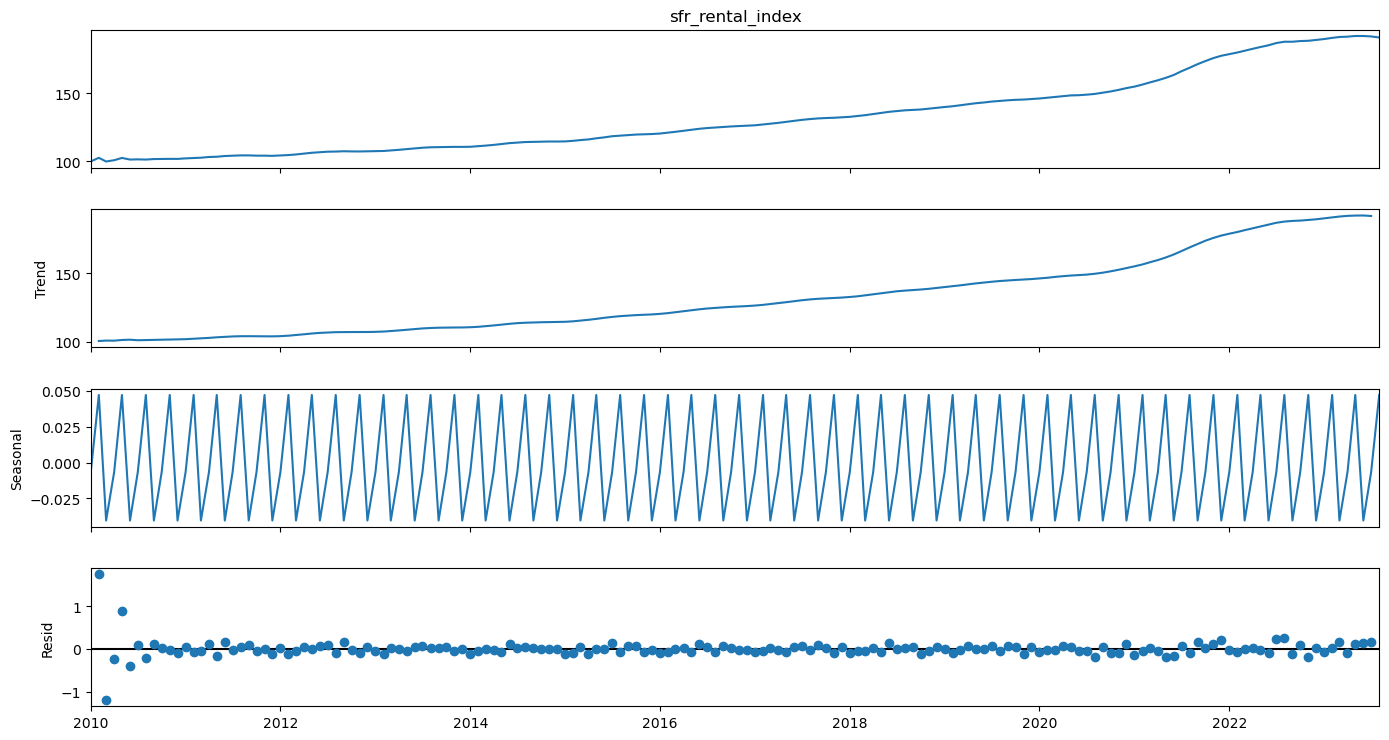

In [4]:
df_sub = data[data['census_zcta5_geoid'] == '30002']

res = sm.tsa.seasonal_decompose(df_sub['sfr_rental_index'].dropna(), period = 3) # by monthly

fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [5]:
#train_test_split
tr_start,tr_end = '2015-01-01','2022-07-01'
te_start,te_end = '2022-08-01','2023-08-01'
tra = df_sub['sfr_rental_index'][tr_start:tr_end].dropna()
tes = df_sub['sfr_rental_index'][te_start:te_end].dropna()

In [8]:
tra.head()

date
2015-01-01    114.715608
2015-02-01    115.155485
2015-03-01    115.694032
2015-04-01    116.181280
2015-05-01    117.000157
Name: sfr_rental_index, dtype: float64

In [11]:
# Check stationarity (not stationary)
#Time series are stationary if they do not have trend or seasonal effects. 
# Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.

#ADF-test(Original-time-series)
# If we fail to reject null hypothesis (Null Hypothesis (H0): alpha=1), the time series is non-stationary - this is rather obvious from the plots above
res = sm.tsa.adfuller(tra.dropna(),regression='ctt')
print('p-value:{}'.format(res[1]))

#ADF-test(differenced-time-series)
res = sm.tsa.adfuller(tra.diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

# NEITHER THE RAW DATA OR THE DIFFERENCE DATA ARE STATIONARY

p-value:0.2445784542178302
p-value:0.8070523790399231


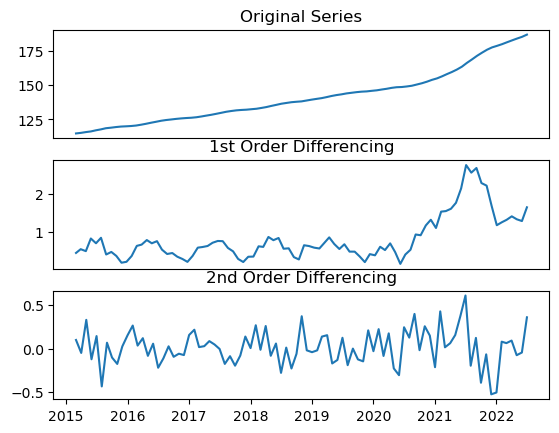

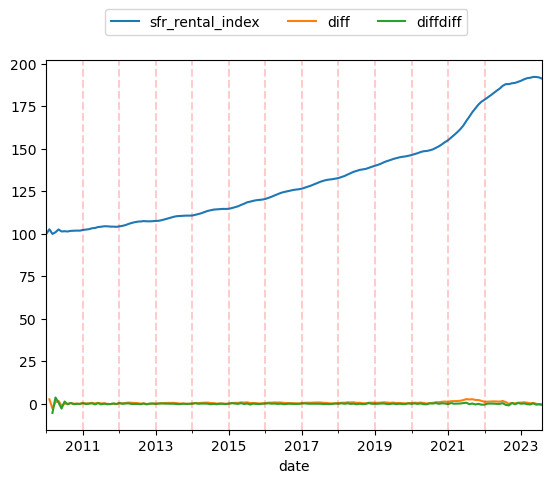

In [12]:
# Finding the appropriate order of differencing (d parameter in ARIMA). 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(tra); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(tra.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(tra.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

# Here 1st order differencing seems to be the best as the trend is mostly removed and the time series appears stationary
# 2nd order differencing is probably over differencing but we will confirm with autocorrelation plots below

# ALSO to see how trend is removed and data become stationary
#acf -> remove trend 
df_sub["diff"] = df_sub['sfr_rental_index'].diff()
df_sub['diffdiff'] = df_sub['sfr_rental_index'].diff().diff()
tmp = df_sub[['sfr_rental_index', 'diff', 'diffdiff']]
ax = tmp.plot()
ax.legend(ncol=5, 
          loc='upper center',
          bbox_to_anchor=(0.5, 1.0),
          bbox_transform=plt.gcf().transFigure)
for yr in range(2010, 2023):
    ax.axvline(pd.to_datetime(str(yr)+"-01-01"), color ="red", linestyle = "--", alpha = 0.2)

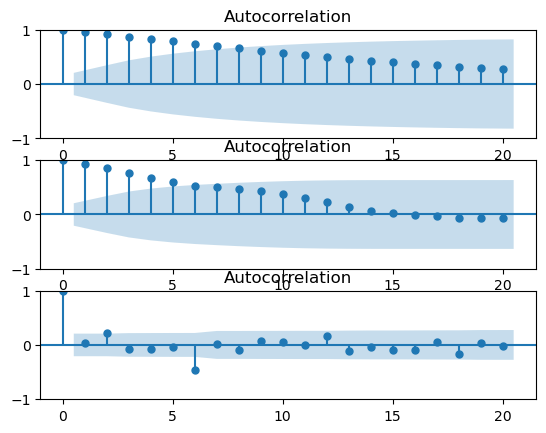

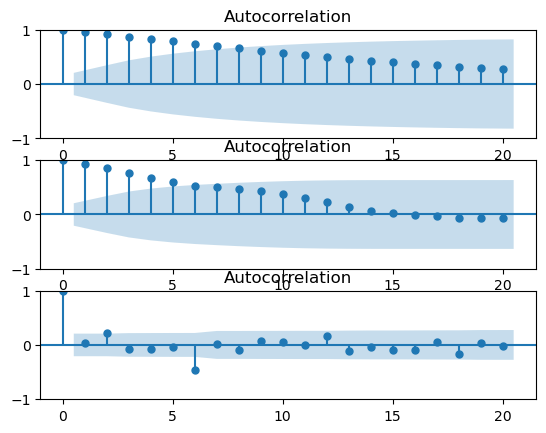

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(tra, ax=ax1)
plot_acf(tra.diff().dropna(), ax=ax2)
plot_acf(tra.diff().diff().dropna(), ax=ax3)

# Final decision: 1st order differencing

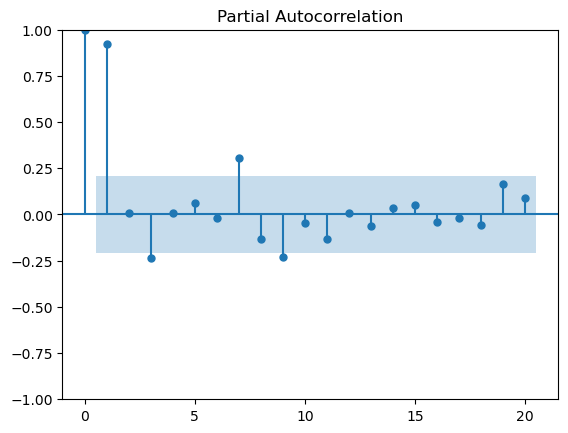

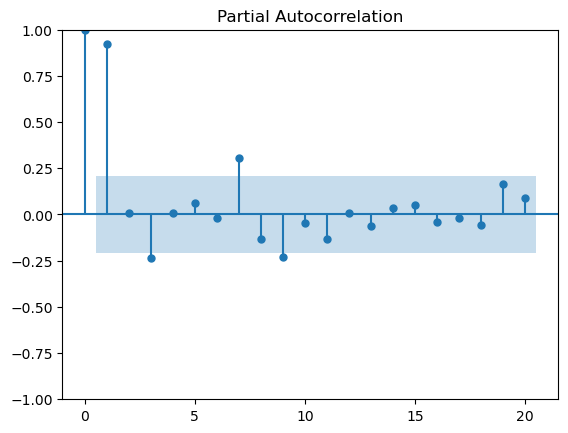

In [18]:
#The partial autocorrelation function plot can be used to draw a correlation 
# between the time series and its lag while the contribution from intermediate lags can be ignored.
# Significant correlation in a stationary time series can be represented by adding auto regression terms. 
# Using the PACF plot we can take the order of AR terms to be equal to the lags that can cross a significance limit. 
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(tra.diff().dropna())

# Select order of p = 1 (1 significant lag)

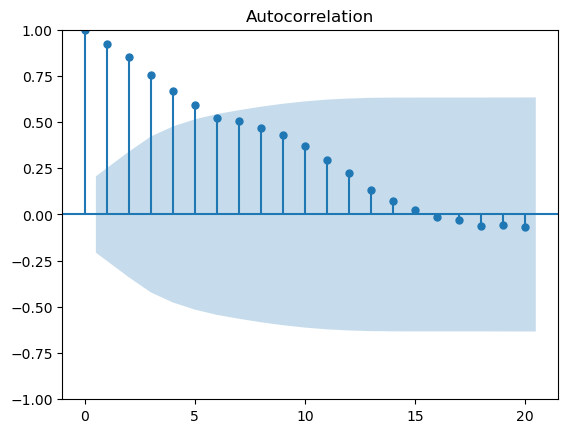

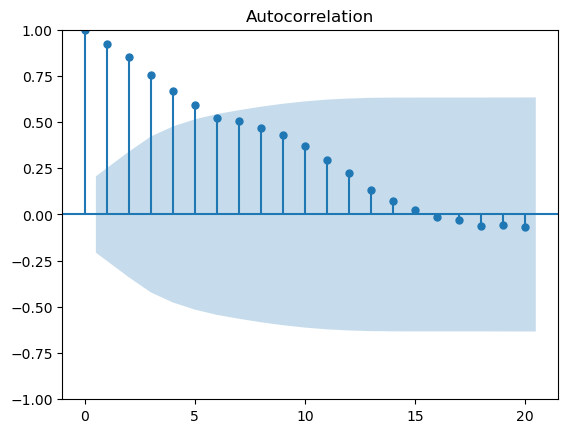

In [19]:
# Determine q parameter (the size of the moving average window required to remove autocorrelation)
plot_acf(tra.diff().dropna())

# q = 6

In [22]:
# Estimate the best value for P parameter - the number of autoregressive terms
resDiff = sm.tsa.arma_order_select_ic(tra.diff(), max_ar=4, max_ma=4, ic='aic', trend='c')


/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eihwood/opt/miniforge3/lib/py

In [23]:
#p is the number of autoregressive terms, (3)
#d is the number of nonseasonal differences, (1)
#q is the number of lagged forecast errors in the prediction equation (5)

print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (3, 4) is the best.


In [29]:
# FIT ARIMA WITH NO SEASONAL COMPONENTS
arima = sm.tsa.statespace.SARIMAX(tra,
                                  order=(3,1,4), 
                                  seasonal_order=(0,0,0,0),
                                  enforce_stationarity=False, enforce_invertibility=False).fit()
arima.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) .


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.85340D-01    |proj g|=  9.96541D-02

At iterate    5    f= -1.90587D-01    |proj g|=  5.16893D-02

At iterate   10    f= -2.03003D-01    |proj g|=  1.44486D-01

At iterate   15    f= -2.13566D-01    |proj g|=  9.94073D-02

At iterate   20    f= -2.42409D-01    |proj g|=  3.73522D-01

At iterate   25    f= -2.54013D-01    |proj g|=  1.57060D-02

At iterate   30    f= -2.55048D-01    |proj g|=  6.57089D-02

At iterate   35    f= -2.56367D-01    |proj g|=  1.57968D-02

At iterate   40    f= -2.56626D-01    |proj g|=  6.91527D-03

At iterate   45    f= -2.56673D-01    |proj g|=  4.00415D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       sfr_rental_index   No. Observations:                   91
Model:               SARIMAX(3, 1, 4)   Log Likelihood                  23.357
Date:                Wed, 04 Oct 2023   AIC                            -30.715
Time:                        13:31:04   BIC                            -11.173
Sample:                    01-01-2015   HQIC                           -22.855
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7781      0.133      5.848      0.000       0.517       1.039
ar.L2         -0.4145      0.181     -2.295      0.022      -0.768      -0.061
ar.L3          0.5868      0.151      3.890      0.000       0.291       0.882
ma.L1          0.3410    599.659      0.001      1.000   -1174.970    1175.651
ma.L2          1.1063   1007.467      0.001      0.999   -1973.494    1975.706
ma.L3         -0.0150    381.294  -3.94e-05      1.000    -747.338     747.308
ma.L4          0.6023    806.962      0.001      0.999   -1581.014    1582.219
sigma2         0.0312     41.824      0.001      0.999     -81.941      82.004
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.91   Prob(JB):                         0.56
Heteroskedasticity (H):               3.28   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Notes on warning: Covariance matrix culculated using the outer product of gradients (complex-step).

- This warning is actually more like a "note" than a "warning". It's just letting you know how the covariance matrix was computed.

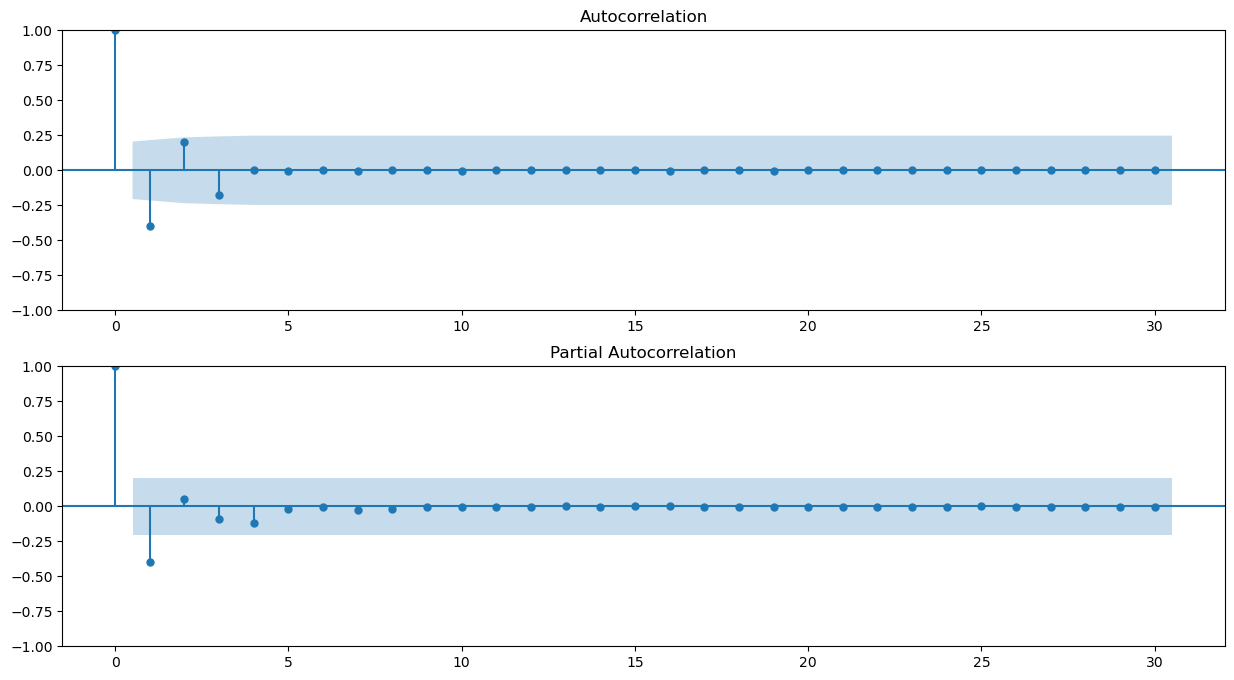

In [30]:


# Check model autocorrelation
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

In [31]:
pred = arima.predict(tr_end,te_end)[1:]
print('ARIMA model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMA model MSE:55.40335198077166


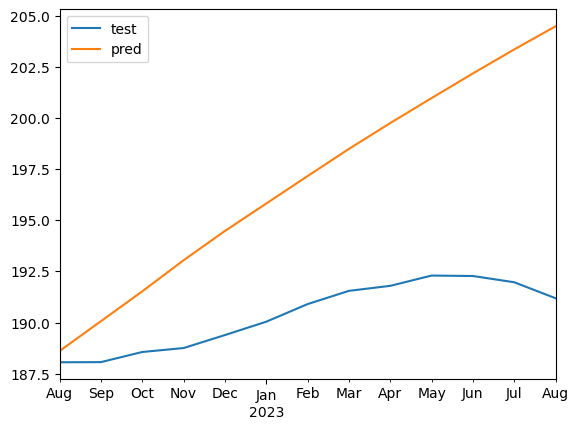

In [32]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()


To determine the parameter values for Seasonality we will again use the ACF/PACF plots. Choosing values for each parameter is not a precise exercise, these are rules of thumb and it will take iterations to get the correct model parameters.

 - Seasonal Period (m)
Our seasonal period m, is the number of periods in each season. We can identify this from the ACF and PACF plot where our value m is equal to the lag with the greatest autocorrelation coefficient. The 0 value is always 1 because it has perfect correlation with the current timestep. If our data is seasonal we'd expect that the next most correlated value to the current timestep would be the equivalent point in the season exactly one season ago. The seasonal period value will also help us determine P and Q.

- Seasonal Autoregressive Order (P)
Our seasonal autoregressive order can be thought about just like our autoregressive order except instead of finding the order of past timesteps that influence the value at the current timestep, we are looking for past timesteps on the order of seasons of m, the seasonal period. This is why the mth lag is also used to determine the value of P. If the lag m has a positive value then P should be >= 1. Otherwise P should be 0. We can fit the model with a value of 1 and increment as we see fit.

- Seasonal Difference Order (D)
The rule of thumb for our D parameter is that our series differencing and seasonal differencing should not be greater than 2. If our seasonal pattern is stable overtime then we can set D=1 and set D=0 if the seasonal pattern seems unstable.

- Seasonal Moving Average Order (Q)
We determine Q much like we determine P. If the lag m, is negative then Q >= 1- the opposite of how we fit P. We generally do not want P+Q to exceed 2. We want to keep our parameter values low because there is a high risk to overfit as we use increasingly complex models.

Lambda Value -1.9925715536762518


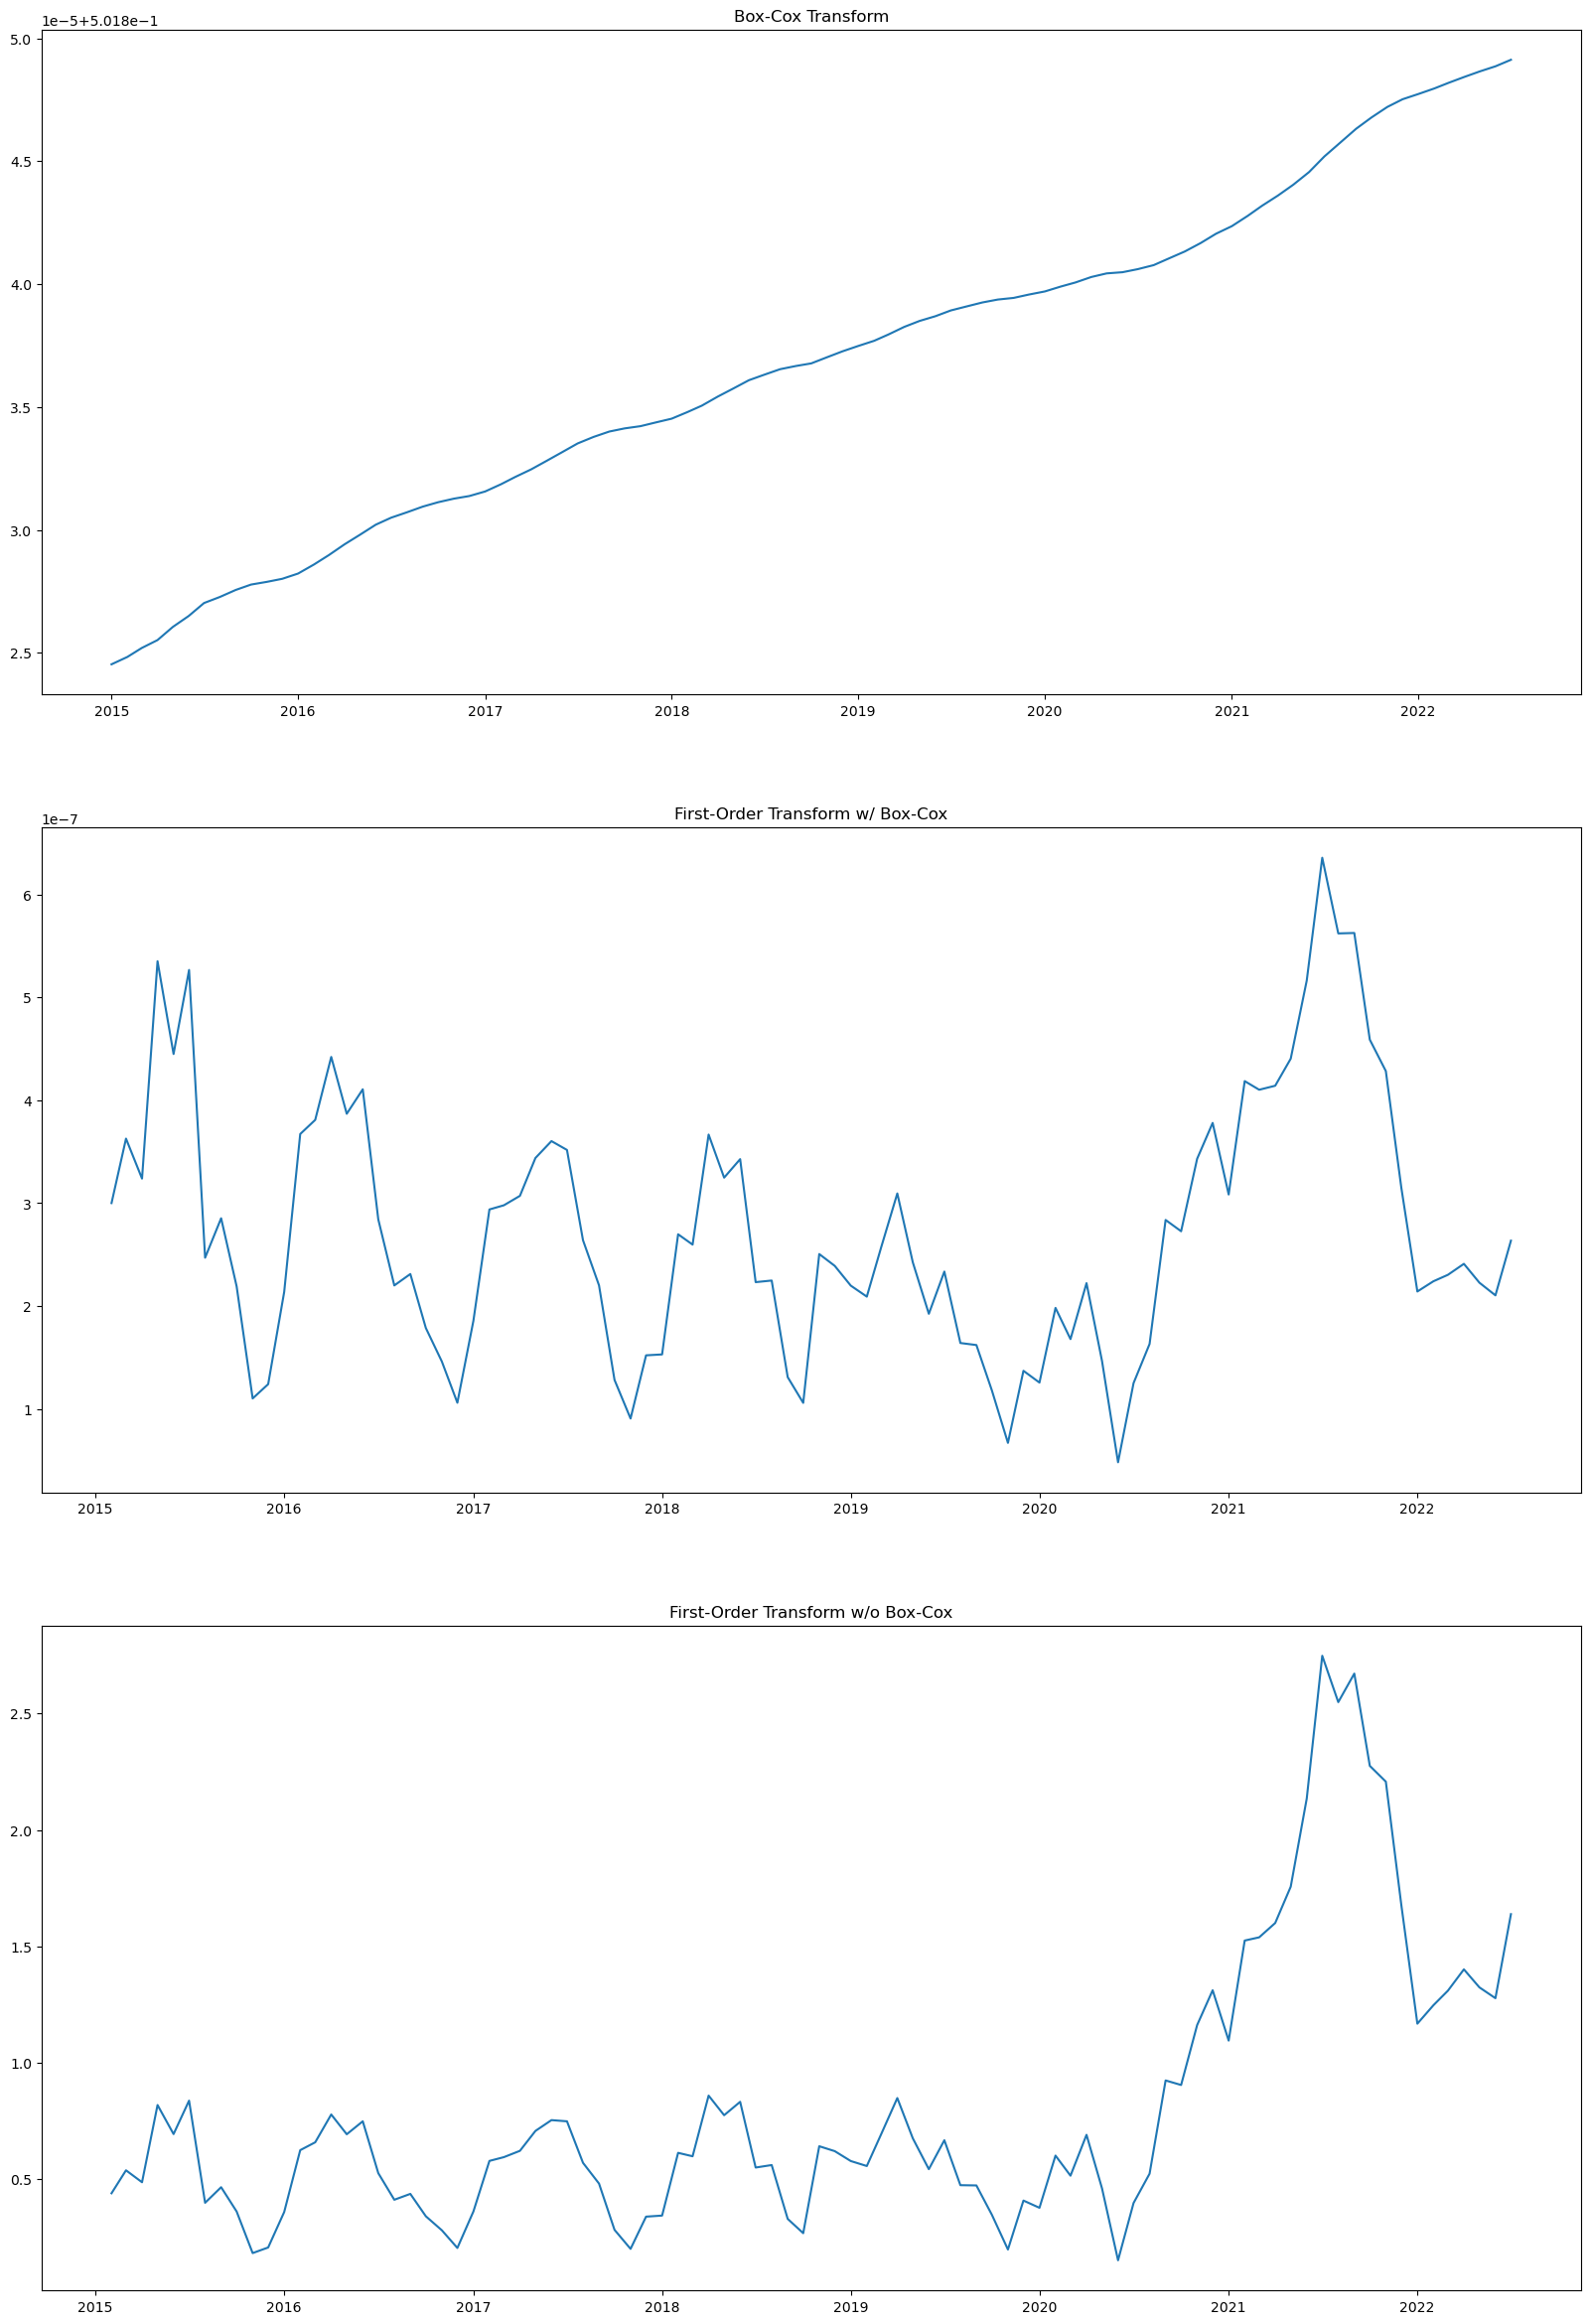

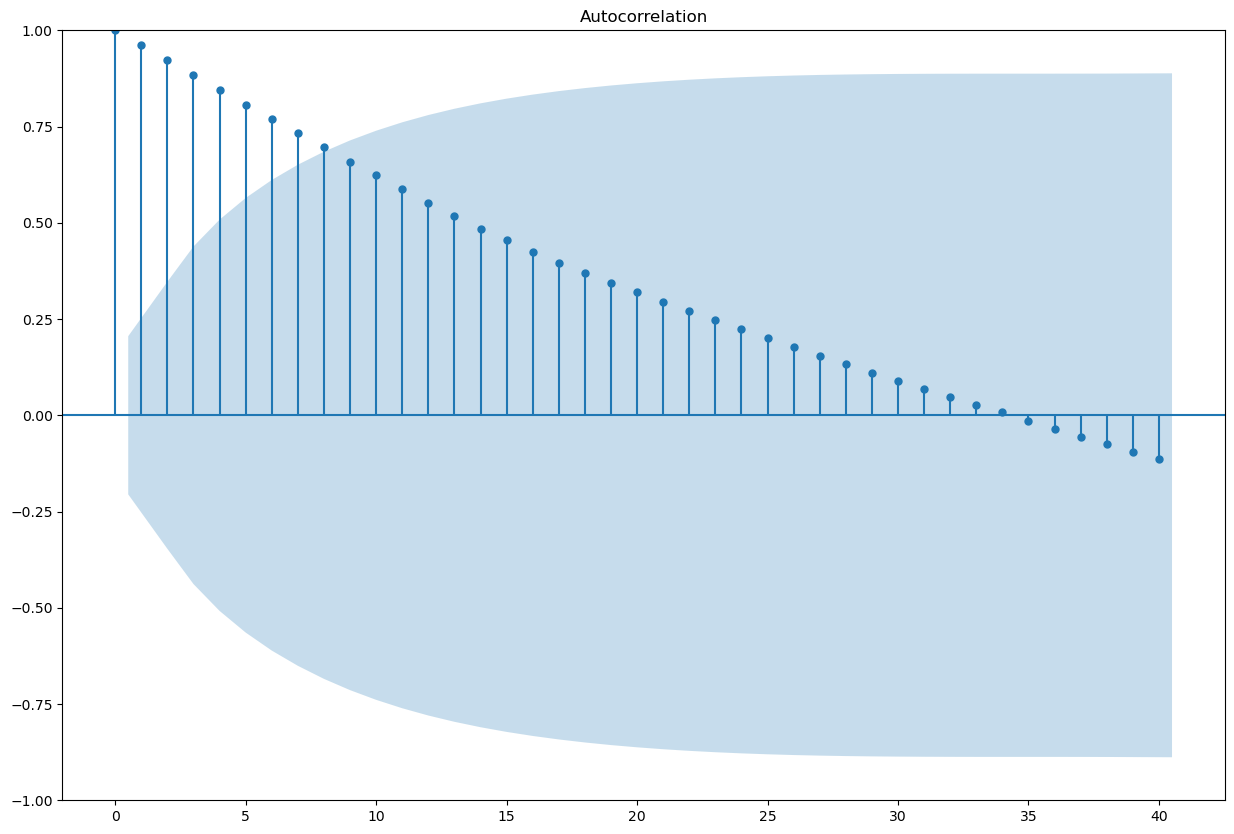

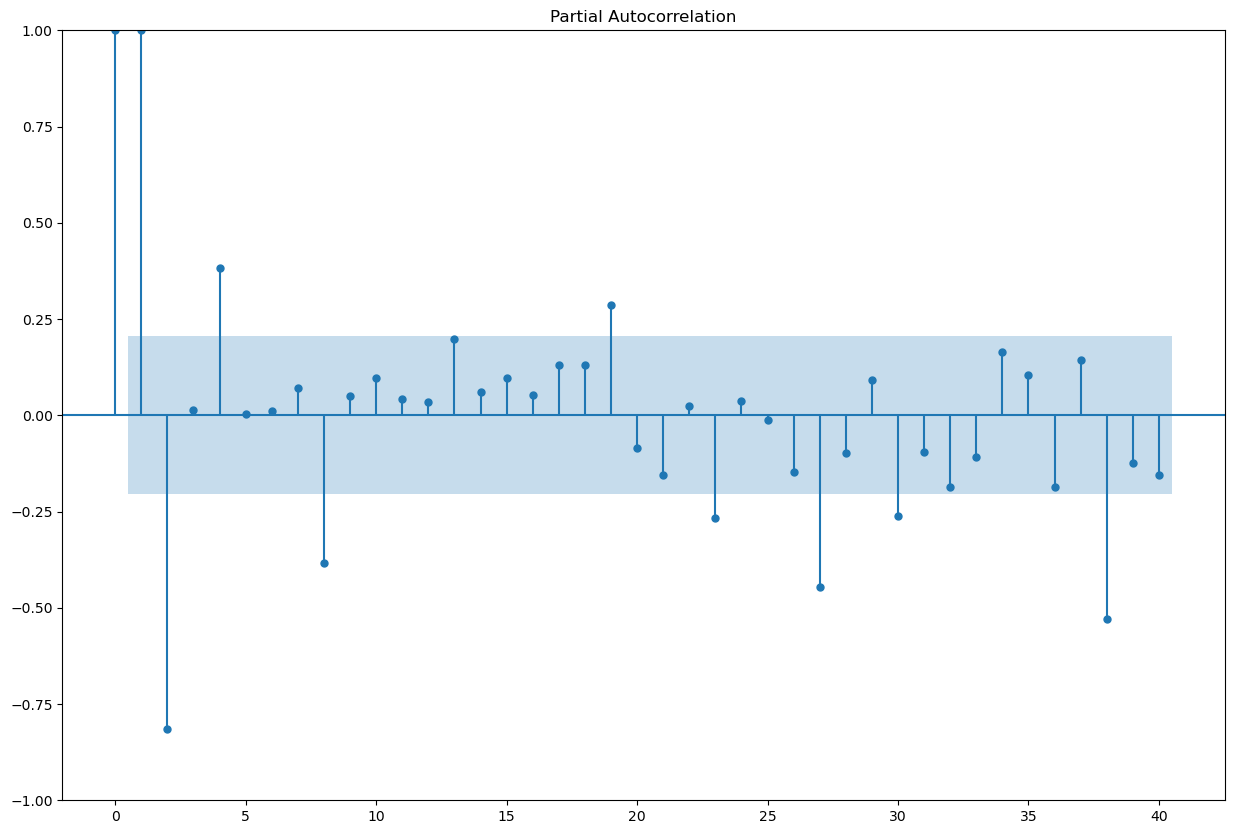

In [34]:
# FIT SEASONAL ARIMA (SARIMA)
## Estimate
#P: Seasonal Autoregressive order
#D: Seasonal difference order
#Q: Seasonal moving average order
#m: The number of time steps for a single seasonal period
# Specified as  SARIMA(p,d,q)(P,D,Q)[m]
df = df_sub[tr_start:tr_end].copy()

df['bc_rpi'], lamb = stats.boxcox(df['sfr_rental_index'])
df['df1_rpi'] = df['bc_rpi'].diff()
df['df_rpi'] = df['sfr_rental_index'].diff()
fig = plt.figure(figsize=(20,40))

bc = plt.subplot(411)
bc.plot(df.bc_rpi)
bc.title.set_text('Box-Cox Transform')
df1 = plt.subplot(412)
df1.plot(df.df1_rpi)
df1.title.set_text('First-Order Transform w/ Box-Cox')
df2 = plt.subplot(413)
df2.plot(df.df_rpi)
df2.title.set_text('First-Order Transform w/o Box-Cox')


print(f'Lambda Value {lamb}')


# M - Our seasonal period m, is the number of periods in each season. 
# We can identify this from the ACF and PACF plot where our value 
# m is equal to the lag with the greatest autocorrelation coefficient. 
# The 0 value is always 1 because it has perfect correlation with the current timestep. 
#If our data is seasonal we'd expect that the next most correlated value to the current timestep would be the equivalent point in the season exactly one season ago. The seasonal period value will also help us determine P and Q.
f_acf = plot_acf(df['bc_rpi'], lags=40)
f_pacf = plot_pacf(df['bc_rpi'], lags=40, method='ols')
f_acf.set_figheight(10)
f_acf.set_figwidth(15)
f_pacf.set_figheight(10)
f_pacf.set_figwidth(15)
plt.show()

In [42]:
sarima = sm.tsa.statespace.SARIMAX(tra,
                                  order=(0,1,4), 
                                  seasonal_order=(3,0,0,3),
                                  enforce_stationarity=False, enforce_invertibility=False).fit()
sarima.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21303D+00    |proj g|=  9.12928D-01

At iterate    5    f= -1.28409D-01    |proj g|=  1.97405D+00

At iterate   10    f= -1.52388D-01    |proj g|=  3.01721D-01

At iterate   15    f= -1.74557D-01    |proj g|=  1.77701D-01

At iterate   20    f= -2.27718D-01    |proj g|=  6.77490D-01

At iterate   25    f= -2.49316D-01    |proj g|=  7.44932D-02

At iterate   30    f= -2.56110D-01    |proj g|=  1.35270D-01

At iterate   35    f= -2.59059D-01    |proj g|=  7.94877D-02

At iterate   40    f= -2.62113D-01    |proj g|=  2.39156D-02

At iterate   45    f= -2.62311D-01    |proj g|=  6.63539D-02

At iterate   50    f= -2.63101D-01    |proj g|=  3.38927D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   sfr_rental_index   No. Observations:                   91
Model:             SARIMAX(0, 1, 4)x(3, 0, [], 3)   Log Likelihood                  23.942
Date:                            Wed, 04 Oct 2023   AIC                            -31.884
Time:                                    13:35:16   BIC                            -12.729
Sample:                                01-01-2015   HQIC                           -24.199
                                     - 07-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.8410      0.529      3.480      0.001       0.804       2.878
ma.L2          5.5958      2.284      2.450      0.014       1.120      10.072
ma.L3          4.5451      2.237      2.032      0.042       0.161       8.929
ma.L4          3.6769      2.135      1.722      0.085      -0.507       7.861
ar.S.L3        0.8941      0.111      8.090      0.000       0.677       1.111
ar.S.L6       -0.4491      0.159     -2.831      0.005      -0.760      -0.138
ar.S.L9        0.4571      0.114      4.014      0.000       0.234       0.680
sigma2         0.0021      0.002      0.966      0.334      -0.002       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                 3.74
Prob(Q):                              0.49   Prob(JB):                         0.15
Heteroskedasticity (H):               5.76   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### pred = sarima.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(tes,pred)))
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()


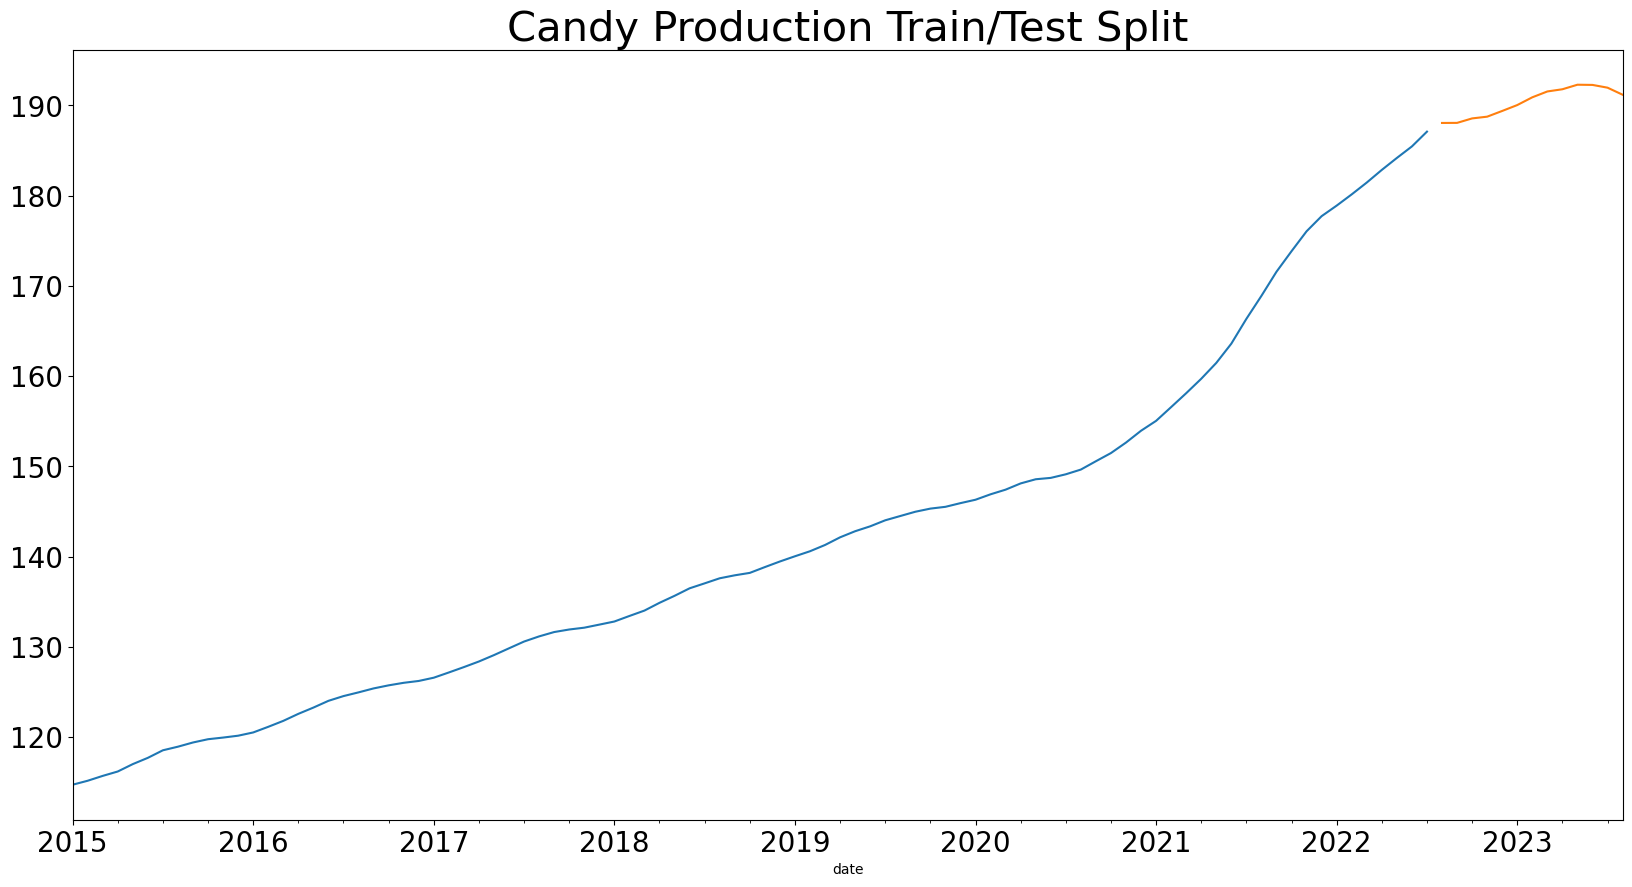

In [43]:
tra.plot(figsize=(20, 10), fontsize=20)
plt.title('SFR Rent Index Train/Test Split', fontsize=30)
tes.plot()
plt.show()

Mean Squared Error: 47.931661499024344
Root Mean Squared Error: 6.923269567121039
Mean Absolute Error: 6.143040897708117


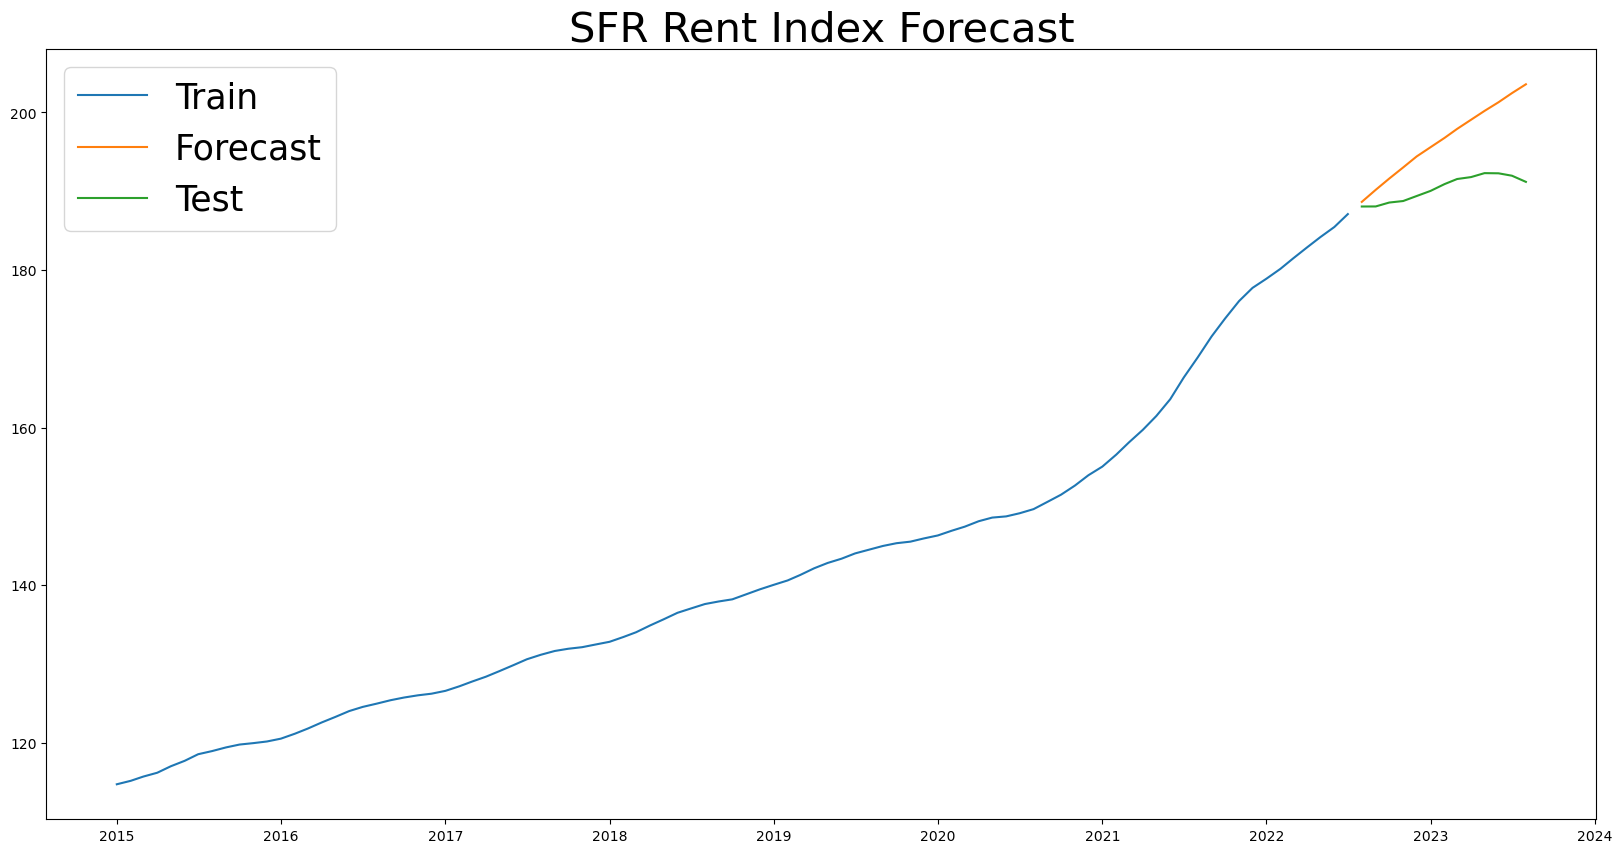

In [47]:
from sklearn.metrics import mean_absolute_error
fcast_len = len(tes)
fcast = sarima.forecast(fcast_len)
mse = mean_squared_error(tes, fcast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(tes, fcast)
plt.figure(figsize=(20, 10))
plt.title('SFR Rent Index Forecast', fontsize=30)
plt.plot(tra, label='Train')
plt.plot(fcast, label='Forecast')
plt.plot(tes, label='Test')

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
plt.legend(fontsize=25)
plt.show()

## NOW WITH EXOGENOUS VARIABLES 

In [ ]:
X = 
arimax = sm.tsa.statespace.SARIMAX(tra,
                                  order=(3,1,4), 
                                  seasonal_order=(0,0,0,0),
                                  enforce_stationarity=False, enforce_invertibility=False).fit()
arima.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) .
